# 2D section inversion:
## Forward Model 1D: Empymod
## Inversion 1D: Pygimli inversion
## No lateral constraints

In [1]:
#%matplotlib notebook

In [2]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg

Dualem coil configurations:

In [3]:
# Receivers geometry

offsets = np.array([2, 4, 8]) # in meters
height = -0.10 # meter height from ground surface to center of coil
rad = 0.08 # Define radius of coil

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers =[offsets-rad, offsets+rad, np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
Psource = [0, 0, height]
Preceivers = [offsets, offsets*0, height]

# Frequency

freq = 9000

In [34]:
# Create forward modeller class

class EMforward(pg.Modelling):
    
    def __init__(self):
        """Initialize the model."""
        super().__init__()
        
    def response(self, x):
        
        surface = np.array([0])
        thkx = np.array(x[0:2])
        depthx = np.hstack((surface, thkx[0], thkx[0]+thkx[1]))
        res_ground = np.array(x[2:])
        res_air = np.array([2e14])
        resx = np.hstack((res_air, res_ground))
        HCP_Hs = empymod.loop(Hsource, Hreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        VCP_Hs = empymod.loop(Vsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        PRP_Hs = empymod.dipole(Psource, Preceivers, depthx, resx, freq, ab = 64, xdirect = None, verb = 0)
    
        HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=res_air[0], freqtime=freq, mrec = 'loop', verb=0)
        VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=res_air[0], freqtime=freq, mrec = 'loop', verb=0)
        PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=res_air[0], freqtime = freq, ab = 66, verb = 0)

        Q_HCP = np.abs(np.imag(HCP_Hs/HCP_Hp))
        Q_VCP = np.abs(np.imag(VCP_Hs/VCP_Hp))
        Q_PRP = np.abs(np.imag(PRP_Hs/PRP_Hp))

        P_HCP = np.abs(np.real(HCP_Hs/HCP_Hp))
        P_VCP = np.abs(np.real(VCP_Hs/VCP_Hp))
        P_PRP = np.abs(np.real(PRP_Hs/PRP_Hp))
        
        # Normalize values by distance
    
        Q_HCP[0] = Q_HCP[0]*16
        Q_HCP[1] = Q_HCP[1]*4
        Q_VCP[0] = Q_VCP[0]*16
        Q_VCP[1] = Q_VCP[1]*4
        Q_PRP[0] = Q_PRP[0]*16
        Q_PRP[1] = Q_PRP[1]*4

        P_HCP[0] = P_HCP[0]*16
        P_HCP[1] = P_HCP[1]*4
        P_VCP[0] = P_VCP[0]*16
        P_VCP[1] = P_VCP[1]*4
        P_PRP[0] = P_PRP[0]*16
        P_PRP[1] = P_PRP[1]*4
           
        return np.hstack((Q_HCP, Q_VCP, Q_PRP, P_HCP, P_VCP, P_PRP))
               
    def createStartModel(self, dataVals):
        
        thk_ini = [3, 4]
        res_ini = [10, 10, 10]
        x0 = thk_ini + res_ini
        return np.array(x0)

In [35]:
# parameters for the synthetic model

nlayer = 3 # number of layer
npos = 20 # number of sampling positions

resistivities = [10,50,10]
res = np.ones((npos, nlayer))*resistivities
x = np.linspace(0, 20, npos)[:,None]
thk1 = 2 + 0.2 * np.sin(x*np.pi*2) # wave
thk2 = 2 + np.sin(x*np.pi*2) # wave
depthmax = 10
ny = 50



In [36]:
# Arrays for plotting
y = np.linspace(0, depthmax, ny)
xx = np.linspace(0,npos+1,npos+1, endpoint=False) # For step plot

def PlotResistivities(thk1, thk2, res, npos, ny, Model):
    surface = np.zeros(npos)
    depth = np.zeros((npos,4))

    # Depths to be plotted
    for i in range(npos):
        depth[i,0] = 0
        depth[i,1] = thk1[i]
        depth[i,2] = thk1[i] + thk2[i]
        depth[i,3] = thk1[i] + thk2[i]
        
    resy = np.zeros((npos, ny))

    # Resistivities array to be plotted
    for i in range(npos):
        y1=0
        while y[y1] <= depth[i, 1]:
            resy[i, y1] = res[i, 0]
            y1 += 1
            y2=y1
        while y[y2] <= depth[i, 2]:
            resy[i, y2] = res[i, 1]
            y2 += 1
            if y2 == 50:
                break
        resy[i, y2:] = res[i, 2]
        
    fig, ax = plt.subplots()
    pos = ax.imshow(resy.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], vmin=10, vmax=50)
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Resistivity [Ohm . m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')
    ax.set_title(Model)
        
    return depth, resy

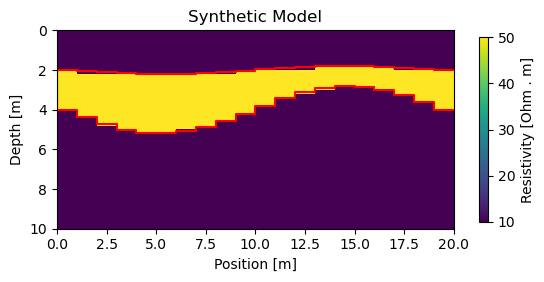

In [37]:
#Plot synthetic model

depth, resy = PlotResistivities(thk1, thk2, res, npos, ny, 'Synthetic Model')

plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])),'r')




In [38]:
# Parameters for initial model

resistivities_ini = [10, 10, 10]
res_ini = np.ones((npos, nlayer))*resistivities_ini
thk1_ini = np.ones(npos)*3
thk2_ini = np.ones(npos)*4


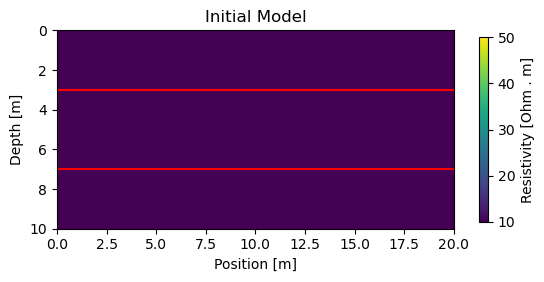

In [39]:
# Plot initial model

depth_ini, resy_ini = PlotResistivities(thk1_ini, thk2_ini, res_ini, npos, ny, 'Initial Model')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth_ini[0,1], depth_ini[:,1], depth_ini[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth_ini[0,1], depth_ini[:,2], depth_ini[-1,2])),'r')

Set-up Inversion

In [40]:
# Define inversion transformations

transData = pg.trans.TransLog() # log transformation for data
transModel = pg.trans.TransLog()  # log-transform ensures thk>0

# Create inversion

EMf = EMforward()
invEM = pg.Inversion()
invEM.setForwardOperator(EMf)

invEM.transModel = transModel
invEM.transData = transData


In [41]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data = []

for i in range(npos):
    model_i = np.array([thk1[i][0], thk2[i][0]]+resistivities) # True model 
    model.append(model_i)
    data.append(EMf(model_i)) # creating data

# Relative error array
error = 1e-2 # introduce here the error you want to test
relativeError = np.ones_like(data[0]) * error

In [42]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):
    
    dataE = np.array(data[i]).copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invEM.run(dataE, relativeError, verbose=False, lam=1, maxIter=40, dPhi=0.01)
    
    model_est_list.append(model_est)

# Model estimation array    
model_est_arr = np.array(model_est_list)

11/11/22 - 14:44:58 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]
11/11/22 - 14:44:58 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:44:59 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]
11/11/22 - 14:44:59 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]
11/11/22 - 14:45:00 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:00 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:01 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:01 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]
11/11/22 - 14:45:01 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:02 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:02 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:03 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:03 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:04 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:05 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:05 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:05 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:06 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]
11/11/22 - 14:45:06 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


11/11/22 - 14:45:07 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 10 10 10]


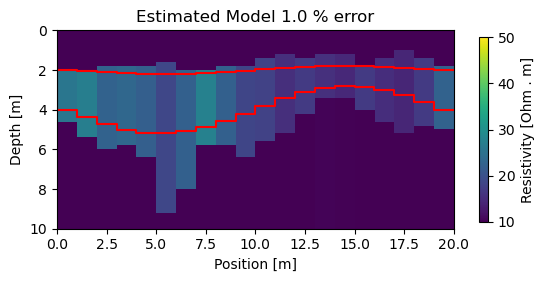

In [43]:
# Plot estimated model

depth_,resy_ = PlotResistivities(model_est_arr[:,0], model_est_arr[:,1], model_est_arr[:,2:] , npos, ny,
                                 'Estimated Model ' + str(error*100) + ' % error')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])), 'r')

